### Scatter plot comparisons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import pickle
import seaborn as sns
import xarray as xr
import cmocean
import geo_tools
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##### Parameters

Tuning sets:
1. sediment in ice = 0.015, resuspension constant = 1.0 (up to spin-up3)
2. sediment in ice = 0.030, resuspension constant = 1.0 (up to spin-up7)
3. sediment in ice = 0.015, resuspension constant = 2.0 (up to spin-up7)
4. sediment in ice = 0.030, resuspension constant = 4.0 (up to spin-up5)
5. sediment in ice = 0.030, resuspension constant = 2.5 (up to ref-2015)

In [2]:
# domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

month   = 8
# results to load:
oldref_2015  = '/data/brogalla/run_storage/Mn-set4-202004/ref-2015/ANHA12_EXH006_2015_monthly.nc'
tuning5_2015 = '/data/brogalla/run_storage/Mn-tuning-202012/ref-2015-tuning5/ANHA12_EXH006_2015_monthly.nc'
tuning5_spinup4 = '/data/brogalla/run_storage/Mn-tuning-202012/spin-up4-tuning5/ANHA12_EXH006_2002_monthly.nc'
tuning5_spinup7 = '/data/brogalla/run_storage/Mn-tuning-202012/spin-up7-tuning5/ANHA12_EXH006_2002_monthly.nc'
tuning2_spinup7 = '/data/brogalla/run_storage/Mn-tuning-202012/spin-up7-tuning2/ANHA12_EXH006_2002_monthly.nc'
tuning3_spinup7 = '/data/brogalla/run_storage/Mn-tuning-202012/spin-up7-tuning3/ANHA12_EXH006_2002_monthly.nc'
tuning4_spinup5 = '/data/brogalla/run_storage/Mn-tuning-202012/spin-up5-tuning4/ANHA12_EXH006_2002_monthly.nc'
tuning1_spinup3 = '/data/brogalla/run_storage/Mn-tuning-202012/spin-up3-tuning1/ANHA12_EXH006_2002_monthly.nc'
tuning2_spinup3 = '/data/brogalla/run_storage/Mn-tuning-202012/spin-up3-tuning2/ANHA12_EXH006_2002_monthly.nc'
tuning5_spinup5 = '/data/brogalla/run_storage/Mn-tuning-202012/spin-up5-tuning5/ANHA12_EXH006_2002_monthly.nc'

# colours:
c_continent    = '#ce9169'
c_glacier      = '#36ab92'
c_other        = '#a6a6a6'
land_color     = "#8b7765"

In [3]:
file_list = [oldref_2015, tuning2_spinup7, tuning3_spinup7, tuning4_spinup5, tuning5_spinup7, \
             tuning5_2015, tuning1_spinup3, tuning2_spinup3, tuning5_spinup5]

##### Load files

In [4]:
Mn_model     = nc.Dataset(oldref_2015)
lon_model    = np.array(Mn_model.variables['nav_lon'])
lat_model    = np.array(Mn_model.variables['nav_lat'])
depths_model = np.array(Mn_model.variables['deptht'])

In [5]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [6]:
mask     = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh_zgr10.nc')
tmask    = mask.variables['tmask']
tmask    = np.array(tmask[0,:,:,:])
mlons    = np.array(mask.variables['nav_lon'])
mlats    = np.array(mask.variables['nav_lat'])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask)

Observations

In [7]:
station_names = ['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
                'CB1', 'CB2', 'CB3', 'CB4']
station_stdev = ['Unnamed: 17', 'Unnamed: 20','Unnamed: 26', 'Unnamed: 29', 'Unnamed: 32', 'Unnamed: 35', \
                 'Unnamed: 38', 'Unnamed: 41','Unnamed: 44', 'Unnamed: 47', 'Unnamed: 50', 'Unnamed: 53']
station_depth = ['Depth.5','Depth.6','Depth.7','Depth.8','Depth.9','Depth.10','Depth.11','Depth.12','Depth.13', \
                'Depth.14','Depth.15','Depth.16','Depth.17']

In [28]:
observations = {'dissolmn': np.zeros((13,25)), 
                'stdev':np.zeros((13,25)), 
                'depth':np.zeros((13,25))} # dimensions: stations, depths
Mn_data      = pd.read_csv('/data/brogalla/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

for it, stn in enumerate(station_names):
    length = len(Mn_data[stn].dropna()[1:].astype('float'))
    observations['dissolmn'][it][0:length] = Mn_data[stn].dropna()[1:].astype('float')
        
for it, stn in enumerate(station_stdev):
    if stn=='Unnamed: 44':
        length = 11
        observations['stdev'][it][0:length] = Mn_data[stn][1:].astype('float').fillna(0)[0:11]
    elif stn=='Unnamed: 50':
        length = 22
        observations['stdev'][it][0:length] = Mn_data[stn][1:].astype('float').fillna(0)[0:22];
    else:
        length = len(Mn_data[stn].dropna()[1:].astype('float'))
        observations['stdev'][it][0:length] = Mn_data[stn].dropna()[1:].astype('float')
        
for it, stn in enumerate(station_depth):
    length = len(Mn_data[stn].dropna())
    observations['depth'][it][0:length]    = Mn_data[stn].dropna()

In [29]:
observations['dissolmn'][observations['dissolmn'] == 0] = np.nan

Mask bottom values of CAA2 and CAA7 (extreme spikes)

In [30]:
#CAA2:
observations['dissolmn'][1,11] = np.nan
#CAA7:
# observations['dissolmn'][6,6]  = np.nan
observations['dissolmn'][6,7]  = np.nan

In [31]:
Pb_data   = pd.read_csv('/data/brogalla/Pb-paper-data.csv')
stn_names = Pb_data['Station names'][5:].dropna().astype('str')
lons      = Pb_data['station lon'][5:].astype('float').dropna().values
lats      = Pb_data['Station lat'][5:].astype('float').dropna().values

Get indices

In [32]:
stationi = np.empty((len(lons)))
stationj = np.empty((len(lons)))
for it, (lon, lat) in enumerate(zip(lons, lats)):
    i, j = geo_tools.find_closest_model_point(lon, lat, mesh_lon, mesh_lat, tols={
        'NEMO': {'tol_lon': 0.08, 'tol_lat': 0.015},
        })
    stationi[it] = i
    stationj[it] = j

In [33]:
stationi[2] = stationi[2]+1 # otherwise I think it's on land

In [34]:
# Match the depths of the observations with the model depths:
stationk = np.empty((13,25))
for stn in range(0,len(lons)):
    depths_obs = observations['depth'][stn,:]
    depths_obs[depths_obs==0] = np.nan
    for ind, depth in enumerate(depths_obs):
        k = np.argmin(np.abs(depths_model-depth))
        stationk[stn, ind] = k
        
stationk[stationk==0] = np.nan

Load model data

In [35]:
tuning_series = {'dissolmn': np.zeros((len(file_list),13,25))} # dimensions: tuning run, depth, stations
for it, filename in enumerate(file_list):
        data = xr.open_dataset(filename)
        for n, (i, j) in enumerate(zip(stationi, stationj)):
            for ind, k in enumerate(stationk[n,:]):
                try:
                    tuning_series['dissolmn'][it,n,ind] = data['dissolmn'][month,0,int(k),int(i-imin),int(j-jmin)]
                except:
                    tuning_series['dissolmn'][it,n,ind] = np.nan
        data.close()

In [36]:
tuning_series['dissolmn'][tuning_series['dissolmn'] == 0] = np.nan

##### Figure

 order of data: file_list = 
     [oldref_2015, tuning2_spinup7, tuning3_spinup7, tuning4_spinup5, tuning5_spinup7, tuning5_2015]

In [17]:
# Colors:
rivers = '#bada55'
dirty  = '#64707b'
clean  = '#cee7fd'

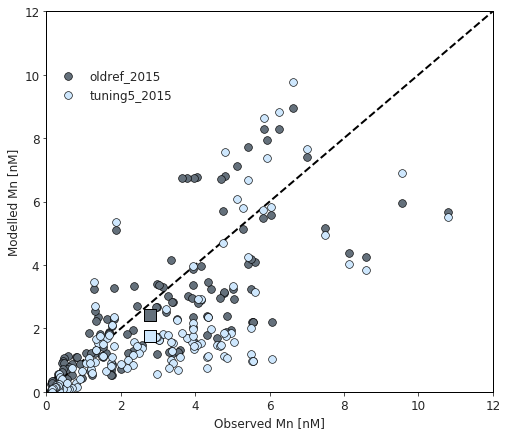

In [27]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

with st:
    ax = sns.lineplot([0, 20],[0, 20], c='k', linewidth=2.0, zorder=1)
    ax.lines[0].set_linestyle('--')
    
    sns.scatterplot(observations['dissolmn'].flatten(), \
                    tuning_series['dissolmn'][0].flatten()*10**9, \
                    label=r'oldref_2015', s=60, edgecolor='k', color=dirty, zorder=2)
    sns.scatterplot(observations['dissolmn'].flatten(), \
                    tuning_series['dissolmn'][5].flatten()*10**9, \
                    label=r'tuning5_2015', s=60, edgecolor='k', color=clean, zorder=2)
    
    sns.scatterplot([np.nanmean(observations['dissolmn'].flatten())], \
                    [np.nanmean(tuning_series['dissolmn'][0].flatten()*10**9)], \
                    s=150, linewidth=1.0, edgecolor='k', marker='s', color=dirty, zorder=3)
    sns.scatterplot([np.nanmean(observations['dissolmn'].flatten())], \
                    [np.nanmean(tuning_series['dissolmn'][5].flatten()*10**9)], \
                    s=150, linewidth=1.0, edgecolor='k', marker='s', color=clean, zorder=3)

    ax.set_xlabel('Observed Mn [nM]', fontsize=12)
    ax.set_ylabel('Modelled Mn [nM]',fontsize=12)
    ax.set(xlim=(0, 12.), ylim=(0, 12.))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc=(0.01, 0.75), frameon=False, fontsize=12)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    
    
# figure = plt.gcf()
# figure.set_size_inches(4.5, 3.7)

###### different parameter sets

Tuning sets:
1. sediment in ice = 0.015, resuspension constant = 1.0 (up to spin-up3)
2. sediment in ice = 0.030, resuspension constant = 1.0 (up to spin-up7)
3. sediment in ice = 0.015, resuspension constant = 2.0 (up to spin-up7)
4. sediment in ice = 0.030, resuspension constant = 4.0 (up to spin-up5)
5. sediment in ice = 0.030, resuspension constant = 2.5 (up to ref-2015)

order of data: file_list = [oldref_2015, tuning2_spinup7, tuning3_spinup7, tuning4_spinup5, tuning5_spinup7, tuning5_2015, tuning1_spinup3, tuning2_spinup3, tuning5_spinup5]

In [18]:
c_tuning1 = '#ffe040'
c_tuning2 = '#7fa5f2'
c_tuning3 = '#9370db'
c_tuning4 = '#80d6ab'
c_tuning5 = '#9a004d'

In [37]:
# x-axis: year of spin-up
# y-axis: mean deviation from observations
# each runset has 1 color
resus  = (tuning_series['dissolmn'][4]-tuning_series['dissolmn'][1])/(2.5-1.0) # at spin-up7
sedice = (tuning_series['dissolmn'][7]-tuning_series['dissolmn'][6])/(0.030-0.015) # at spin-up3

In [38]:
# OR use 2015 tuning5 estimate to alter the other points

resus_rate = np.linspace(0,12,100) # sediment resuspension rate constant
sed_ice    = np.linspace(0,0.35,100) # background sea ice sediment content
parameter_sets = {'resus_rate': np.zeros((100,100)), 'sed_ice':np.zeros((100,100)), \
                  'model_diff':np.zeros((100,100))}

mean_obs = np.nanmean(observations['dissolmn'].flatten())

for it, r_param in enumerate(resus_rate):
    for jt, si_param in enumerate(sed_ice):
        parameter_sets['resus_rate'][it,jt] = r_param
        parameter_sets['sed_ice'][it,jt]    = si_param 
        
        mod      = tuning_series['dissolmn'][5] - (0.030*sedice + 2.5*resus) \
                            + resus*r_param + sedice*si_param 
        mean_mod = np.nanmean(mod.flatten()*10**9)
        
        parameter_sets['model_diff'][it,jt] = mean_mod - mean_obs

In [39]:
max_depth = np.nanmax(observations['depth'],axis=1)
depth_bdy = max_depth - 100 # for looking at the bottom, calculate the bottom depth

In [40]:
# OR use 2015 tuning5 estimate to alter the other points

resus_rate = np.linspace(0,20,100) # sediment resuspension rate constant
sed_ice    = np.linspace(0,0.35,100) # background sea ice sediment content
bottom_parameter_sets = {'resus_rate': np.zeros((100,100)), 'sed_ice':np.zeros((100,100)), \
                         'model_diff':np.zeros((100,100))}

for it, r_param in enumerate(resus_rate):
    for jt, si_param in enumerate(sed_ice):
        bottom_parameter_sets['resus_rate'][it,jt] = r_param
        bottom_parameter_sets['sed_ice'][it,jt]    = si_param 
        
        bottom_obs = np.zeros(13)
        bottom_mod = np.zeros(13)
        for stn, depth_lim in enumerate(depth_bdy):     
            mod = tuning_series['dissolmn'][5,stn,:][observations['depth'][stn,:] > depth_lim] - \
                        (0.030*sedice[stn,:][observations['depth'][stn,:] > depth_lim] + \
                         2.5*resus[stn,:][observations['depth'][stn,:] > depth_lim]) \
                        + resus[stn,:][observations['depth'][stn,:] > depth_lim]*r_param + \
                        sedice[stn,:][observations['depth'][stn,:] > depth_lim]*si_param 
            bottom_obs[stn] = np.nanmean(observations['dissolmn'][stn,:][observations['depth'][stn,:] > depth_lim])
            bottom_mod[stn] = np.nanmean(mod.flatten()*10**9)

        bottom_parameter_sets['model_diff'][it,jt] = np.nanmean(bottom_mod) - np.nanmean(bottom_obs)

In [41]:
# OR use 2015 tuning5 estimate to alter the other points

resus_rate = np.linspace(0,12,100) # sediment resuspension rate constant
sed_ice    = np.linspace(0,0.35,100) # background sea ice sediment content
upper_parameter_sets = {'resus_rate': np.zeros((100,100)), 'sed_ice':np.zeros((100,100)), \
                         'model_diff':np.zeros((100,100))}

upper_obs = np.nanmean(observations['dissolmn'][observations['depth'] < 100])

for it, r_param in enumerate(resus_rate):
    for jt, si_param in enumerate(sed_ice):
        upper_parameter_sets['resus_rate'][it,jt] = r_param
        upper_parameter_sets['sed_ice'][it,jt]    = si_param 
        
        upper_mod = tuning_series['dissolmn'][5][observations['depth'] < 100] - \
                    (0.030*sedice[observations['depth'] < 100] + 2.5*resus[observations['depth'] < 100]) \
                    + resus[observations['depth'] < 100]*r_param + sedice[observations['depth'] < 100]*si_param 
        upper_mod = np.nanmean(upper_mod.flatten()*10**9)
        
        upper_parameter_sets['model_diff'][it,jt] = upper_mod - upper_obs

In [43]:
# Bring spinup experiment --> future

# tuning2_spinup7: 0.030, 1.0
tuning2_2015 = tuning_series['dissolmn'][1]+(tuning_series['dissolmn'][5] - tuning_series['dissolmn'][4])
# tuning3_spinup7: 0.015, 2.0
tuning3_2015 = tuning_series['dissolmn'][2]+(tuning_series['dissolmn'][5] - tuning_series['dissolmn'][4])
# tuning4_spinup5: 0.030, 4.0
tuning4_2015 = tuning_series['dissolmn'][3]+(tuning_series['dissolmn'][5] - tuning_series['dissolmn'][8])

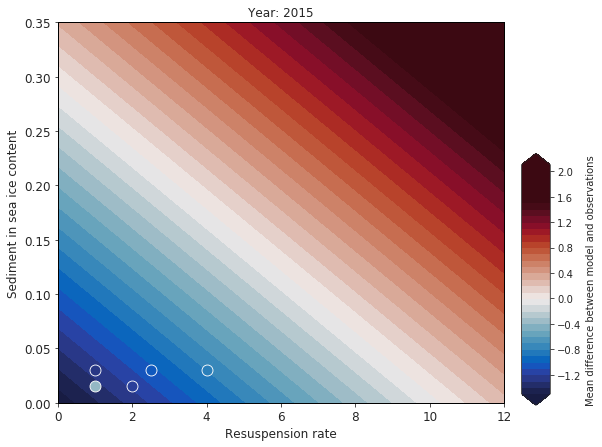

In [44]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1.5
vup  = 1.5

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(parameter_sets['resus_rate'], \
                      parameter_sets['sed_ice'], \
                      parameter_sets['model_diff'], \
                      cmap=cmocean.cm.balance, levels=40, vmin=vlow, vmax=vup, extend='both')
    
    sns.scatterplot([2.5], [0.030], \
                    c=[np.nanmean(tuning_series['dissolmn'][5].flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([1.0], [0.030], \
                    c=[np.nanmean(tuning2_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([2.0], [0.015], \
                    c=[np.nanmean(tuning3_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([1.0], [0.015], \
                    c=[np.nanmean(tuning_series['dissolmn'][0].flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([4.0], [0.030], \
                    c=[np.nanmean(tuning4_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)

    ax.set_xlabel('Resuspension rate', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015', fontsize=12)
    ax.set(xlim=(0, 12.0), ylim=(0, 0.35))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    

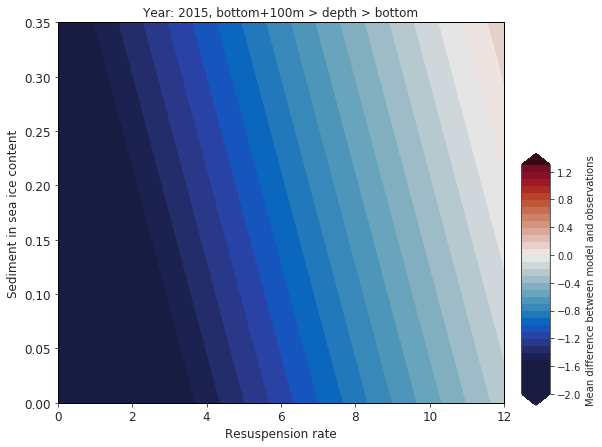

In [45]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1.5
vup  = 1.5

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(bottom_parameter_sets['resus_rate'], \
                      bottom_parameter_sets['sed_ice'], \
                      bottom_parameter_sets['model_diff'], \
                      cmap=cmocean.cm.balance, levels=40, vmin=vlow, vmax=vup, extend='both')
    
    ax.set_xlabel('Resuspension rate', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015, bottom+100m > depth > bottom', fontsize=12)
    ax.set(xlim=(0, 12.0), ylim=(0, 0.35))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    

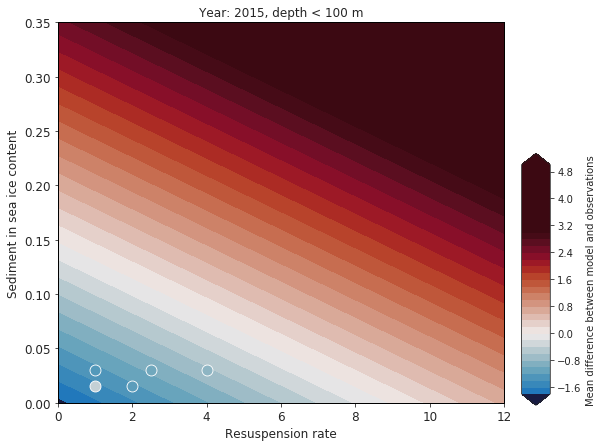

In [46]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -3
vup  = 3

with st:
#     ax = sns.scatterplot(parameter_sets['resus_rate'].flatten(), \
#                          parameter_sets['sed_ice'].flatten(), \
#                          c=parameter_sets['model_diff'].flatten(), \
#                          cmap=cmocean.cm.balance, vmin = -1.0, vmax = 1.0, s=10, zorder=2)
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(upper_parameter_sets['resus_rate'], \
                      upper_parameter_sets['sed_ice'], \
                      upper_parameter_sets['model_diff'], \
                      cmap=cmocean.cm.balance, levels=40, vmin=vlow, vmax=vup, extend='both')
    
    sns.scatterplot([2.5], [0.030], \
                    c=[np.nanmean(tuning_series['dissolmn'][5].flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([1.0], [0.030], \
                    c=[np.nanmean(tuning2_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([2.0], [0.015], \
                    c=[np.nanmean(tuning3_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([1.0], [0.015], \
                    c=[np.nanmean(tuning_series['dissolmn'][0].flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([4.0], [0.030], \
                    c=[np.nanmean(tuning4_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)

    ax.set_xlabel('Resuspension rate', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015, depth < 100 m', fontsize=12)
    ax.set(xlim=(0, 12.0), ylim=(0, 0.35))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    

Figure explained:
1. The point that is very different from the background is the mean difference for the old reference run in 2015
2. One scatter point is the mean difference between the model and observation profiles for the newest tuning run that went all the way to 2015
3. Three scatter points are tuning2 and tuning3 (up to spinup7), and tuning4 (up to spinup5), projected into the future based on how much the full run changed between that point in spin up and 2015. 
4. Contour plot: I started with the 2015 tuning5 estimate and subtracted from this the contributions from 0.030 sediment content in sea ice and 2.5 resuspension rate (calculated using the difference between several tuning runs). Then, I estimated the mean difference between the model and observations while varying the resususpension rate between 0-12 and sediment content in sea ice between 0-0.35.